In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import importlib

from convnet.struct.loss import SoftmaxCrossEntropyLoss

project_root = os.path.abspath('/Users/subhojit/workspace/saturn/src')
if project_root not in sys.path:
    sys.path.append(project_root)
import convnet.struct
from convnet.data_loader import CIFAR_10_DataLoader
from convnet.struct.layers import Linear, ReLU, Model

importlib.reload(convnet.struct.layers)

%matplotlib inline

In [14]:
file_directory = '/Users/subhojit/Downloads/cifar-10-batches-py'
cdl = CIFAR_10_DataLoader()
xtrain_data, ytrain_data, Xtest, ytest = cdl.load_cifar_10_dataset(file_directory)

xtrain_data = xtrain_data.astype('float32') / 255.0
Xtest = Xtest.astype('float32') / 255.0

# np.random.shuffle(Xtrain)
n1 = int(0.8 * len(xtrain_data))
Xtrain = xtrain_data[:n1]
ytrain = ytrain_data[:n1]
Xdev = xtrain_data[n1:]
ydev = ytrain_data[n1:]

num_classes = len(set(ytrain))

In [15]:
# data preparation
np.random.seed(231)
std_dev = 1e-2
n_hidden = 300

layers = [
    Linear(3072, n_hidden, std_dev=std_dev),                ReLU(),
    Linear(n_hidden, n_hidden, std_dev=std_dev),            ReLU(),
    Linear(n_hidden, n_hidden, std_dev=std_dev),            ReLU(),
    Linear(n_hidden, num_classes, std_dev=std_dev)
]

model = Model(layers)
loss_criteria = SoftmaxCrossEntropyLoss()

params = [p for layer in layers for p in layer.parameters()]

print(sum(par.size for par in params))

1105510


In [16]:
max_iterations = 10000
batch_size = 128
lossi = []
Hs = []

for i in range(max_iterations):

    #mini batch
    ix = np.random.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[ix], ytrain[ix]

    #farward pass
    x = Xb
    logits = model.forward(x)
    loss = loss_criteria.forward(logits, Yb)
    lossi.append(loss)

    #backward pass
    logit_grad = loss_criteria.backward()
    model.backward(logit_grad)

    #param update
    lr = 0.1
    model.update_param(lr)

    if i % 100 == 0:
        print(f"loss: {loss:.4f}")

loss: 2.3026
loss: 2.3022
loss: 2.3010
loss: 2.2995
loss: 2.2575
loss: 2.0988
loss: 2.1036
loss: 2.1101
loss: 2.0579
loss: 2.0395
loss: 1.9844
loss: 1.9658
loss: 1.9572
loss: 1.9355
loss: 1.8287
loss: 1.8568
loss: 1.8538
loss: 1.7631
loss: 1.7533
loss: 1.7779
loss: 1.8495
loss: 1.8240
loss: 1.6740
loss: 1.6044
loss: 1.7595
loss: 1.7572
loss: 1.6524
loss: 1.6234
loss: 1.7867
loss: 1.6413
loss: 1.7325
loss: 1.5523
loss: 1.7181
loss: 1.7124
loss: 1.4774
loss: 1.5484
loss: 1.4302
loss: 1.5330
loss: 1.5088
loss: 1.6469
loss: 1.4501
loss: 1.6007
loss: 1.5740
loss: 1.6749
loss: 1.5924
loss: 1.5377
loss: 1.5401
loss: 1.4453
loss: 1.3942
loss: 1.4318
loss: 1.4615
loss: 1.3041
loss: 1.3743
loss: 1.3885
loss: 1.4409
loss: 1.4560
loss: 1.3902
loss: 1.3755
loss: 1.4737
loss: 1.4319
loss: 1.4037
loss: 1.3161
loss: 1.4247
loss: 1.4211
loss: 1.3432
loss: 1.3891
loss: 1.2206
loss: 1.2682
loss: 1.3523
loss: 1.5087
loss: 1.2539
loss: 1.3386
loss: 1.4229
loss: 1.4750
loss: 1.1477
loss: 1.5961
loss: 1.2429

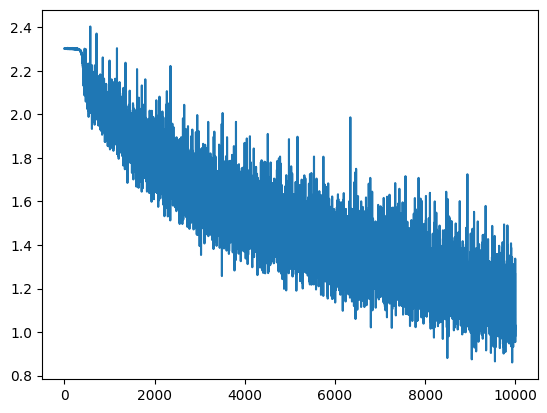

In [17]:
plt.plot(lossi)


In [18]:
def split_loss(split):
    x, y = {
        'train': (Xtrain, ytrain),
        'dev': (Xdev, ydev),
        'test': (Xtest, ytest),
    }[split]
    for layer in layers:
        x = layer.forward(x)
    logits = x
    loss = loss_criteria.forward(logits, y)
    print(f"{split} => loss: {loss:.4f}")

split_loss('train')
split_loss('dev')


train => loss: 1.1022
dev => loss: 1.4092


In [19]:
split_loss('test')

test => loss: 1.3940


In [20]:
def accuracy(x, labels):
    for layer in layers:
        x = layer.forward(x)
    logits = x
    probs = loss_criteria.softmax_numpy(logits)
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == labels)

accuracy(Xtest, ytest)

np.float64(0.5121)